In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from __future__ import print_function, division, absolute_import
import imp
import numpy as np
from scipy import constants

import lsst.daf.persistence as daf_persistence
from lsst.sims.photUtils import Bandpass, PhotometricParameters
from lsst.utils import getPackageDir
imp.load_source('calc_refractive_index', '/Users/sullivan/LSST/code/StarFast/calc_refractive_index.py')
from calc_refractive_index import diff_refraction

In [3]:
def look(img, range=None, x_range=None, y_range=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    plt.figure(figsize=(8, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
    img_use = np.clip(img, range[0], range[1])
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

In [4]:
repository = "/Users/sullivan/LSST/simulations/test6/output_data"
obsid_range = [202, 212, 2]
band_name = "g"

In [172]:
imp.load_source('dcr_1d_correction', '/Users/sullivan/LSST/LSST-DCR/experimental_DCR/python/dcr_1d_correction.py')
from dcr_1d_correction import DcrCorrection

In [173]:
test6_obj = DcrCorrection(wavelength_step=45., repository=repository, obsid_range=obsid_range, band_name=band_name)

In [174]:
test6_obj.build_matrix()

1.83144638063
0.131871600839
-1.2372905268
-1.86944719463
1.52728386043
0.10997061127
-1.03180325337
-1.55897207356
1.28096703245
0.0922347761535
-0.865395925634
-1.30754378272
1.07451849136
0.0773696347378
-0.72592310593
-1.09681146002
0.896453380814
0.0645482237021
-0.605625726142
-0.915051736804


In [175]:
test6_obj.build_inverse_squared_matrix()

In [176]:
test6_obj.build_template()

img_vec shape:  (5120,)
moment_vec shape:  (4096,)
template_vec shape:  (4096,)


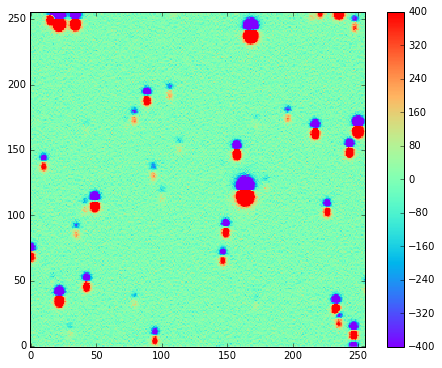

In [177]:
look(test6_obj.template[3]-test6_obj.template[0],range=[-4e2,4e2],x_range=[0,256],y_range=[256,512])

In [170]:
template = np.zeros((test6_obj.y_size, test6_obj.x_size, test6_obj.n_step))
for _i in range(test6_obj.x_size):
    img_vec = np.zeros(test6_obj.y_size * test6_obj.n_images)
    for s_i, image in enumerate(test6_obj.image_arr):
        img_vec[s_i * test6_obj.y_size: (s_i + 1) * test6_obj.y_size] = image[:, _i]
    # img_vec = np.hstack([image[:, _i] for image in self.image_arr])
    moment_vec = np.einsum('ij,j->i', test6_obj.refract_matrix, img_vec)
    template_vec = np.einsum('ij,i->j', test6_obj.matrix_squared, moment_vec)
    for s_i in range(test6_obj.n_step):
        template[:, _i, s_i] = template_vec[s_i * test6_obj.y_size: (s_i + 1) * test6_obj.y_size]
    # template[:, _i, :] = np.reshape(template_vec.T, (self.y_size, self.n_step))
print("img_vec shape: ", img_vec.shape)
print("moment_vec shape: ", moment_vec.shape)
print("template_vec shape: ", template_vec.shape)
bandpass_normalized = test6_obj.bandpass.sb / test6_obj.bandpass.sb.sum()
test6_obj.template = [template[:, :, f_i] * bandpass_normalized[f_i] for f_i in range(test6_obj.n_step)]

img_vec shape:  (5120,)
moment_vec shape:  (4096,)
template_vec shape:  (4096,)


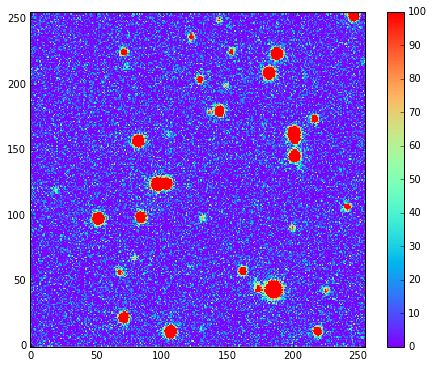

In [64]:
look(test6_obj.image_arr[4],range=[0,1e2],x_range=[0,256],y_range=[0,256])